In [1]:
import networkx as nx
import numpy as np
import seaborn as sb
import scipy
import matplotlib.pyplot as plt
import cvxpy as cp

# Methods

In [2]:
def sup_lower_approx(VV, n):
    return int(np.ceil(1/np.max(VV)))

In [3]:
def lower_approx(VV, n):
    vflat = VV.reshape(n*n)
    res = 0
    count = 0
    while res < 1:
        count += 1
        res += vflat[np.argsort(vflat)[-count]]
    return count

In [4]:
def linear_approx(V2, n):
    x = cp.Variable(n)
    y = cp.Variable(n)
    u = cp.Variable((n,n))

    c1 = cp.sum(cp.multiply(V2, u))
    cx = cp.reshape(x,(n,1)) @ cp.reshape(np.ones([1,n]),(1,n))
    cy = cp.reshape(np.ones([1,n]),(n,1)) @ cp.reshape(y,(1,n))

    constraints = [cp.vec(u) >= 0, cp.vec(u) <= 1, 0 <= x, x <= 1, 0 <= y, y <= 1, c1 >= 1, u <= cx, u <= cy, cx + cy - 1  <= u]
    prob = cp.Problem(cp.Minimize(cp.sum(u)),constraints)
    return int(np.ceil(prob.solve()))

In [5]:
def sdp_approx(VV, n):
    x = cp.Variable(2*n)
    u = cp.Variable((2*n,2*n))
    
    Z = np.zeros((n,n))
    O = np.ones((n,n))
    Vsym = np.concatenate((np.concatenate((Z,0.5*VV), axis =1), np.concatenate((0.5*VV.T, Z), axis =1)))
    Idsym = np.concatenate((np.concatenate((Z,0.5*O), axis =1), np.concatenate((0.5*O, Z), axis =1)))

    c1 = cp.sum(cp.multiply(Vsym, u))
    cx = cp.reshape(x,(2*n,1)) @ cp.reshape(np.ones([1,2*n]),(1,2*n))
    cy = cp.reshape(np.ones([1,2*n]),(2*n,1)) @ cp.reshape(x,(1,2*n))
    ctrace = cp.trace(u - cp.diag(x))
    
    A11= cp.reshape(1, (1, 1))
    A12= cp.reshape(x, (1, 2*n))
    A1 = cp.hstack([A11, A12])

    A21= cp.reshape(x, (2*n,1))
    A22= u
    A2 = cp.hstack([A21, A22])
    M = cp.vstack([A1, A2])
    

    constraints = [cp.vec(u) >= 0, cp.vec(u) <= 1, 0 <= x, x <= 1, c1 >= 1, u <= cx, u <= cy, cx + cy - 1  <= u, ctrace == 0, M >> 0]
    prob = cp.Problem(cp.Minimize(cp.sum(cp.multiply(Idsym, u))), constraints)
    return int(np.ceil(prob.solve()))

In [6]:
def upper_bound_3(VV, n):
    res = []
    for i in range(n):
        print('working...', i)
        for j in range(i+1,n):
            for t in range(j+1, n):
                ind_subset = [i,j,t]
                VV_tr = VV[ind_subset, :]
                sums = np.sum(VV_tr, axis = 0)
                argsorted_sums = np.argsort(sums)
                cumsum = 0
                count = 0
                while cumsum < 1:
                    count += 1
                    cumsum += sums[argsorted_sums[-count]]
                res.append(count*3)
                VV_tr = VV[:,ind_subset]
                sums = np.sum(VV_tr, axis = 1)
                argsorted_sums = np.argsort(sums)
                cumsum = 0
                count = 0
                while cumsum < 1:
                    count += 1
                    cumsum += sums[argsorted_sums[-count]]
                res.append(count*3)
    return np.min(res)

In [7]:
def upper_bound_2(VV, n):
    res = []
    for i in range(n):
        for j in range(i+1,n):
            ind_subset = [i,j]
            VV_tr = VV[ind_subset, :]
            sums = np.sum(VV_tr, axis = 0)
            argsorted_sums = np.argsort(sums)
            cumsum = 0
            count = 0
            while cumsum < 1:
                count += 1
                cumsum += sums[argsorted_sums[-count]]
            res.append(count*2)
            VV_tr = VV[:,ind_subset]
            sums = np.sum(VV_tr, axis = 1)
            argsorted_sums = np.argsort(sums)
            cumsum = 0
            count = 0
            while cumsum < 1:
                count += 1
                cumsum += sums[argsorted_sums[-count]]
            res.append(count*2)
    return np.min(res)

# Models

In [21]:
def random_regular(n, d):
    g = nx.random_regular_graph(d, n, seed=None)
    matrix = nx.to_numpy_matrix(g)
    u, V = np.linalg.eigh(matrix)
    VV = np.array(np.multiply(V, V))
    return VV

In [31]:
def modify_adjacency(m, n, k1, k2):
    
    verts = np.random.choice(n, k1, replace=False)

    for i in verts:
        neis = np.random.choice(n, k2, replace=False)
        for j in neis:
            if i != j:
                m[i, j] =1
                m[j, i] = 1
    return m

In [32]:
def random_regular_modified(n, d, k1, k2):
    g = nx.random_regular_graph(d, n, seed=None)
    mat = nx.to_numpy_matrix(g)
    mat_modified = modify_adjacency(mat.copy(), n, k1, k2)
    u, V = np.linalg.eigh(mat_modified)
    VV = np.array(np.multiply(V, V))
    return VV

In [33]:
saves = []
for n in range(25,475,25):
    VV = random_regular(n, 2*int(np.ceil(np.sqrt(n))))
    saves.append(VV)
#with open('test-adjacencies1.pkl','wb') as f:
#     pickle.dump(saves, f)

In [34]:
saves2 = []
for n in range(25,475,25):
    VV2 = random_regular_modified(n, 2*int(np.ceil(np.sqrt(n))), int(np.ceil(0.1*n)), int(np.ceil(0.5*n)))
    saves2.append(VV2)
#with open('test-adjacencies-mod.pkl','wb') as f:
#     pickle.dump(saves, f)

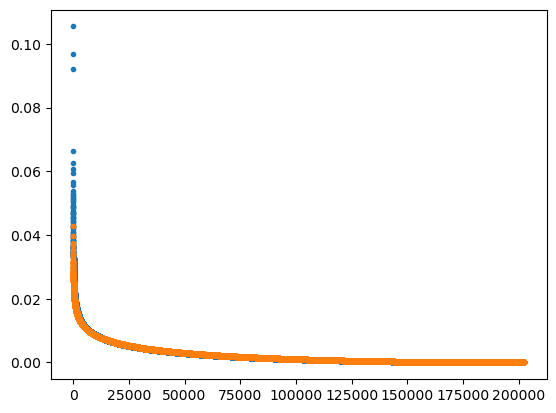

In [35]:
vflat2 = VV2.reshape(n*n)
plt.plot(np.sort(vflat2)[::-1], '.')
vflat1 = VV.reshape(n*n)
plt.plot(np.sort(vflat1)[::-1], '.')
#plt.savefig('decay.png')

In [ ]:
matrices = saves # saves2
#matrices = pickle.load(open("test-adjacencies.pkl", "rb"))
VV = VV # VV2
tries = num_tries # 5 or 1

In [ ]:
linear_lowers = []
sdp_lowers = []
greedy_lowers = []
sup_lowers = []
two_uppers = []
three_uppers = []

for _ in range(tries):
    ll = []
    sl = []
    gl = []
    sdpl = []
    tu = []
    tru = []
    for i in range(14):
        VV = matrices[i]
        n = VV.shape[0]
        print(n)
        sdpl.append(sdp_approx(VV, n))
        print(sdpl)
        print('sdp done')
    
        ll.append(linear_approx(VV, n))
        print('linear done')
        gl.append(lower_approx(VV, n))
        print('greedy done')

        sl.append(sup_lower_approx(VV, n))
        print('sup done')

        x = upper_bound_2(VV, n)
        tu.append(x)
        print('two upper done')
        y = upper_bound_3(VV, n)
        print('three upper done')
        tru.append(y)
        
    print(sdpl)
    sdp_lowers.append(sdpl)
    print(ll)
    linear_lowers.append(ll)
    print(gl)
    greedy_lowers.append(gl)
    print(sl)
    sup_lowers.append(sl)
    print(tu)
    two_uppers.append(tu)
    print(tru)
    three_uppers.append(tru)
        


In [14]:
# Running the above we get the following numbers:

In [15]:
linear1 =     [5, 7,  9,  10, 12, 13, 15, 17, 18, 19, 23, 23, 26, 27]
greedy1 =     [5, 7,  8,  9,  11, 12, 14, 16, 16, 17, 21, 21, 23, 25]
sup1    =     [4, 5,  6,  9,  10, 10, 11, 13, 12, 15, 16, 16, 18, 22]
two_uppers1 = [8, 14, 20, 28, 34, 40, 50, 58, 64, 74, 82, 86, 98, 102]
tre_uppers1 = [9, 15, 21, 24, 33, 39, 48, 54, 63, 69, 78, 84, 96, 99]
min_uppers1 = [8, 14, 20, 24, 33, 39, 48, 54, 63, 69, 78, 84, 96, 99]

linear2 =     [5, 7,  9,  10, 13, 15, 15, 17, 18, 20, 22, 23, 25, 26]
greedy2 =     [5, 7,  8,  8,  12, 14, 14, 16, 17, 18, 20, 20, 22, 24]
sup2 =        [4, 6,  7,  6,  9,  12, 11, 12, 14, 16, 15, 13, 18, 17]
two_uppers2 = [8, 14, 20, 26, 34, 44, 48, 58, 66, 72, 82, 88, 100,106]
tre_uppers2 = [9, 12, 21, 24, 30, 42, 48, 54, 63, 66, 78, 81, 96, 99]
min_uppers2 = [8, 12, 20, 24, 30, 42, 48, 54, 63, 66, 78, 81, 96, 99]

linear3 =     [4, 7,  8,  10, 12, 14, 15, 16, 18, 21, 22, 23, 24, 27]
greedy3 =     [4, 6,  7,  9,  10, 12, 14, 14, 16, 19, 20, 20, 21, 26]
sup3 =        [3, 5,  6,  7,  7,  8,  12, 11, 12, 15, 17, 13, 17, 18]
two_uppers3 = [6, 14, 22, 30, 34, 40, 50, 56, 68, 74, 80, 90, 96, 106]
tre_uppers3 = [6, 12, 21, 27, 33, 39, 48, 54, 63, 69, 75, 87, 93, 99]
min_uppers3 = [6, 12, 21, 27, 33, 39, 48, 54, 63, 69, 75, 87, 93, 99]

linear4 =     [4, 6,  8,  10, 12, 13, 16, 16, 19, 20, 22, 23, 25, 26]
greedy4 =     [4, 5,  7,  9,  11, 12, 15, 14, 17, 19, 20, 21, 23, 23]
sup4 =        [4, 4,  6,  7,  10, 11, 11, 12, 13, 17, 14, 13, 18, 15]
two_uppers4 = [6, 12, 18, 26, 34, 42, 52, 56, 66, 76, 76, 90, 96, 106]
tre_uppers4 = [6, 15, 18, 24, 33, 36, 48, 51, 63, 72, 75, 87, 90, 99]
min_uppers4 = [6, 12, 18, 24, 33, 36, 48, 51, 63, 72, 75, 87, 90, 99]

linear5 =     [5, 7,  8,  11, 13, 13, 16, 17, 18, 20, 23, 22, 25, 26]
greedy5 =     [5, 6,  7,  10, 12, 12, 15, 15, 16, 19, 21, 20, 23, 24]
sup5 =        [4, 5,  6,  7,  11, 10, 11, 9,  14, 15, 16, 15, 19, 20]
two_uppers5 = [8, 14, 20, 28, 34, 44, 50, 5,  64, 74, 78, 88, 92, 106]
tre_uppers5 = [9, 15, 18, 27, 30, 42, 48, 51, 60, 72, 78, 84, 87, 99]
min_uppers5 = [8, 14, 18, 27, 30, 42, 48, 51, 60, 72, 78, 84, 87, 99]

sdp =         [7, 9,  11, 13, 16, 17, 19, 21, 24, 25, 28, 29, 32, 34]

linear = np.array([linear1, linear2, linear3, linear4, linear5])
greedy = np.array([greedy1, greedy2, greedy3, greedy4, greedy5])
sup = np.array([sup1, sup2, sup3, sup4, sup5])
two_uppers = np.array([two_uppers1, two_uppers2, two_uppers3, two_uppers4, two_uppers5])
min_uppers = np.array([min_uppers1, min_uppers2, min_uppers3, min_uppers4, min_uppers5])


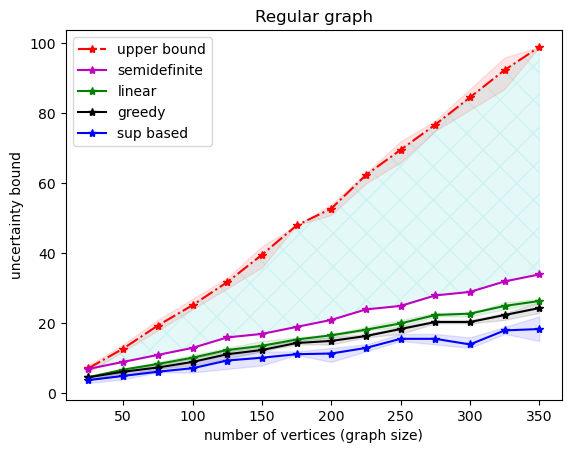

In [17]:
ran = range(25, 375, 25)
plt.title('Regular graph')
plt.plot(ran, np.mean(min_uppers, axis =0), 'r*-.', label = 'upper bound')
plt.plot(ran, sdp,                          'm*-',  label='semidefinite')
plt.plot(ran, np.mean(linear, axis =0),     'g*-',  label='linear')
plt.plot(ran, np.mean(greedy, axis =0),     'k*-',  label = 'greedy')
plt.plot(ran, np.mean(sup, axis = 0),       'b*-',  label = 'sup based')


plt.fill_between(ran, np.min(min_uppers, axis = 0), np.max(min_uppers, axis = 0), color='r', alpha=0.1)
plt.fill_between(ran, np.min(greedy, axis = 0),     np.max(greedy, axis = 0),     color='k', alpha=0.1)
plt.fill_between(ran, np.min(linear, axis = 0),     np.max(linear, axis = 0),     color='g', alpha=0.1)
plt.fill_between(ran, np.min(sup, axis = 0),        np.max(sup, axis = 0),        color='b', alpha=0.1)
plt.fill_between(ran, np.mean(min_uppers, axis =0), sdp, hatch = 'X',             color='c', alpha=0.1)

plt.xlabel("number of vertices (graph size)")
plt.ylabel("uncertainty bound")
plt.legend()
#plt.savefig('regular.png')

In [19]:
linear1_m =     [4, 7,  8,  10, 12, 13, 13, 15, 15, 17, 16, 17, 19, 18, 18]
greedy1_m =     [4, 6,  7,  9,  11, 11, 11, 13, 14, 15, 14, 14, 16, 15, 16]
sup1_m =        [3, 4,  6,  6,  10, 9,  8,  9,  9,  11, 11, 10, 11, 12, 14]
two_uppers1_m = [8, 12, 20, 26, 34, 38, 42, 48, 50, 56, 60, 62, 62, 64, 64]
tre_uppers1_m = [9, 12, 18, 27, 33, 36, 36, 42, 42, 45, 45, 48, 51, 51, 54]
min_uppers1_m = [8, 12, 18, 26, 33, 36, 36, 42, 42, 45, 45, 48, 51, 51, 54]

linear2_m =     [5, 7,  8,  10, 11, 13, 14, 15, 15, 16, 17, 15, 20, 17, 18]
greedy2_m =     [4, 7,  8,  9,  9,  12, 12, 13, 13, 15, 15, 13, 17, 14, 16]
sup2_m =        [4, 6,  7,  7,  7,  10, 9,  9,  11, 12, 10, 8,  13, 12, 11]
two_uppers2_m = [8, 14, 18, 24, 34, 38, 44, 48, 52, 56, 60, 60, 66, 66, 72]
tre_uppers2_m = [9, 15, 21, 24, 30, 33, 39, 42, 42, 45, 48, 48, 54, 51, 54]
min_uppers2_m = [8, 14, 18, 24, 30, 33, 39, 42, 42, 45, 48, 48, 54, 51, 54]

linear3_m =     [5, 7,  8,  11, 11, 13, 14, 16, 15, 16, 16, 16, 17, 18, 19]
greedy3_m =     [4, 6,  8,  10, 10, 12, 13, 14, 14, 14, 14, 14, 14, 16, 16]
sup3_m =        [4, 5,  7,  8,  8,  9,  10, 12, 11, 10, 9,  12, 12, 12, 14]
two_uppers3_m = [6, 14, 18, 28, 32, 40, 44, 48, 50, 50, 52, 60, 62, 72, 74]
tre_uppers3_m = [6, 15, 18, 27, 30, 33, 39, 39, 42, 42, 45, 48, 51, 54, 60]
min_uppers3_m = [6, 14, 18, 27, 30, 33, 39, 39, 42, 42, 45, 48, 51, 54, 60]

linear4_m =     [4, 6,  8,  10, 11, 12, 14, 15, 15, 16, 17, 17, 17, 18, 18]
greedy4_m =     [4, 5,  8,  9,  10, 10, 12, 13, 14, 13, 14, 15, 14, 16, 15]
sup4_m =        [3, 5,  7,  7,  8,  9,  9,  9,  11, 7,  10, 12, 11, 12, 11]
two_uppers4_m = [8, 10, 22, 28, 34, 40, 44, 48, 48, 52, 60, 64, 64, 64, 66]
tre_uppers4_m = [9, 12, 21, 24, 30, 33, 39, 39, 39, 39, 48, 51, 51, 51, 48]
min_uppers4_m = [8, 10, 21, 24, 30, 33, 39, 39, 39, 39, 48, 51, 51, 51, 48]

linear5_m =     [5, 7,  8,  11, 12, 13, 15, 16, 15, 16, 16, 17, 18, 17, 18]
greedy5_m =     [5, 7,  7,  10, 11, 12, 13, 14, 12, 15, 14, 15, 16, 14, 15]
sup5_m =        [4, 6,  5,  8,  10, 10, 11, 10, 9,  12, 10, 12, 12, 10, 11]
two_uppers5_m = [10,14, 20, 28, 30, 38, 40, 46, 50, 52, 56, 62, 68, 60, 68]
tre_uppers5_m = [9, 15, 18, 27, 30, 33, 39, 42, 39, 42, 48, 48, 57, 51, 54]
min_uppers5_m = [9, 14, 18, 27, 30, 33, 39, 42, 39, 42, 48, 48, 57, 51, 54]

sdp_modif =     [6, 9,  11, 13, 15, 17, 18, 20, 20, 22, 23, 25, 26, 26, 27]

sup_modif        = np.array([sup1_m, sup2_m, sup3_m, sup4_m, sup5_m])
linear_modif     = np.array([linear1_m, linear2_m, linear3_m, linear4_m, linear5_m])
greedy_modif     = np.array([greedy1_m, greedy2_m, greedy3_m, greedy4_m, greedy5_m])
min_uppers_modif = np.array([min_uppers1_m, min_uppers2_m, min_uppers3_m, min_uppers4_m, min_uppers5_m])
two_uppers_modif = np.array([two_uppers1_m, two_uppers2_m, two_uppers3_m, two_uppers4_m, two_uppers5_m])
tre_uppers_modif = np.array([tre_uppers1_m, tre_uppers2_m, tre_uppers3_m, tre_uppers4_m, tre_uppers5_m])


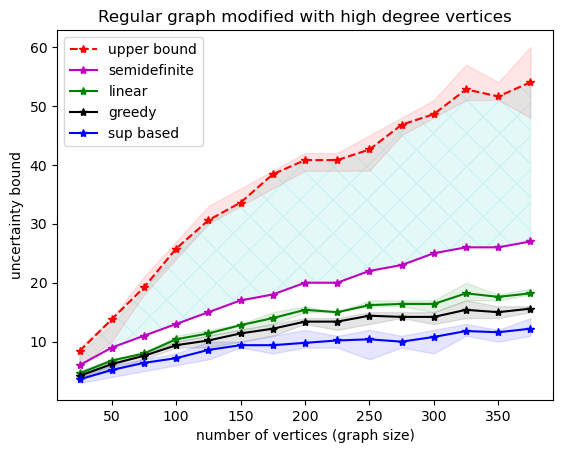

In [20]:
ran = range(25, 400, 25)
plt.title('Regular graph modified with high degree vertices') 
plt.plot(ran, np.mean(tre_uppers_modif, axis =0), 'r*--', label = 'upper bound')
plt.plot(ran, np.array(sdp_modif),                'm*-',  label = 'semidefinite')
plt.plot(ran, np.mean(linear_modif, axis =0),     'g*-',  label = 'linear')
plt.plot(ran, np.mean(greedy_modif, axis =0),     'k*-',  label = 'greedy')
plt.plot(ran, np.mean(sup_modif, axis =0),        'b*-',  label = 'sup based')

plt.fill_between(ran, np.min(min_uppers_modif, axis =0), np.max(min_uppers_modif, axis =0), color='r', alpha=0.1)
plt.fill_between(ran, np.min(greedy_modif, axis =0),     np.max(greedy_modif, axis =0),     color='k', alpha=0.1)
plt.fill_between(ran, np.min(linear_modif, axis =0),     np.max(linear_modif, axis =0),     color='g', alpha=0.1)
plt.fill_between(ran, np.min(sup_modif, axis =0),        np.max(sup_modif, axis =0),        color='b', alpha=0.1)
plt.fill_between(ran, np.mean(min_uppers_modif, axis =0),sdp_modif, hatch = 'X',            color='c', alpha=0.1)
plt.xlabel("number of vertices (graph size)")
plt.ylabel("uncertainty bound")
plt.legend()
#plt.savefig('modified.png')